In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed
import random

Using MPI version 4.0, 1 processes


In [2]:
resolution = 20

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

pml_thickness = 0.780
height_pillar = 1.020
width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a * 3
cell_y = a * 3
cell_z = round(2*pml_thickness + width_PDMS + height_pillar +  width_fusedSilica, 3)

center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
                    + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
z_PDMS = height_pillar + width_PDMS + pml_thickness

In [3]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica)),
            mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    center=mp.Vector3(0,0,center_PDMS),
                    material=mp.Medium(index=n_PDMS))]

k_point = mp.Vector3(0,0,0)
#k_point = mp.Vector3(np.radians(35), 0, 0)  # k vector defines normal to the plane of propagation

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 6 # this is the number of pillars we will build
data = np.zeros((3,num))
dfts = []

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

fcen = freq
#fwidth=0.2*freq
fwidth=0.7741935483870968

# sources = [mp.Source(mp.GaussianSource(fcen, fwidth=fwidth), component = source_cmpt,
#                             center=mp.Vector3(0,0,center_source),
#                             size=mp.Vector3(cell_x,cell_y,0))]
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=fwidth),
                            component = source_cmpt,
                            center=mp.Vector3(0,0,center_source),
                            size=mp.Vector3(cell_x,cell_y,0))]
#testing this as the stop_when_fields_decay point
fr_center = round(0.5*cell_z - pml_thickness - 0.3*width_PDMS, 3)
#def run_sim():
#    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, source_cmpt, mp.Vector3(0, 0, cell_z), 1e-2))

def run_sim():
    sim.run(until_after_sources = mp.stop_when_fields_decayed(50, source_cmpt, mp.Vector3(0, 0, fr_center), 1e-2))

In [4]:
cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    #symmetries=symmetries,
                    resolution=resolution)

df=0;nfreq=1
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))
flux_object = sim.add_flux(freq, df, nfreq, fr)

# where=mp.Volume(center=mp.Vector3(0, 0, fr_center), size=mp.Vector3(cell_x, cell_y, 0))
# dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)

non_pml = 3.36
near_vol = mp.Volume(center = mp.Vector3(0,0,0),
                                size = mp.Vector3(cell_x, cell_y, non_pml))
cs = [mp.Ex, mp.Ey, mp.Ez]
freq_list = [0.346926354230067,0.6060606060606061,0.6451612903225806,0.7692307692307692,0.9433962264150942]

dft_object = sim.add_dft_fields(cs, freq_list, where=near_vol)

run_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.909291 s
-----------
on time step 1243 (time=31.075), 0.00321841 s/step
field decay(t = 50.025000000000006): 0.11629336650951468 / 0.11629336650951468 = 1.0
on time step 2822 (time=70.55), 0.00253391 s/step
field decay(t = 100.05000000000001): 7.036744192440498e-07 / 0.11629336650951468 = 6.050856040756872e-06
run 0 finished at t = 100.05000000000001 (4002 timesteps)


In [5]:
initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux
initial_dft = [sim.get_dft_array(dft_object, mp.Ex, 2),
               sim.get_dft_array(dft_object, mp.Ey, 2),
               sim.get_dft_array(dft_object, mp.Ez, 2)]
sim.reset_meep()
print(initial_flux)
len(initial_dft)


# self.dft_field_ex_1550 = self.sim.get_dft_array(self.near_fields, mp.Ex, 2)
#         self.dft_field_ey_1550 = self.sim.get_dft_array(self.near_fields, mp.Ey, 2)
#         self.dft_field_ez_1550 = self.sim.get_dft_array(self.near_fields, mp.Ez, 2)

0.29201889494133565


3

In [6]:
print(len(initial_dft[0]))
print(len(initial_dft[1]))
print(len(initial_dft[2]))
print(initial_dft[0].shape) # gives (42,42,70) need to get (42,42,fr_slice)

42
42
42
(42, 42, 70)


In [7]:
x_list = [-a, 0, a, -a, 0, a, -a, 0, a]
y_list = [a, a, a, 0, 0, 0, -a, -a, -a] 
radii_list = np.random.uniform(0.075, 0.250, 9)

for i, neighbor in enumerate(radii_list):
    radius = neighbor
    x_dim = x_list[i]
    y_dim = y_list[i]
    geometry.append(mp.Cylinder(radius=radii_list[i],
                                height=height_pillar,
                                axis=mp.Vector3(0,0,1),
                                center=mp.Vector3(x_list[i], y_list[i], center_pillar),
                                material=mp.Medium(index=n_amorphousSi)))


In [21]:
print(radii_list)

[0.07712845 0.18148884 0.16429774 0.14465851 0.13001893 0.12072568
 0.09872153 0.10021467 0.09904243]


In [8]:
pbar = tqdm(total=num,leave=False)
central_index = None
for i,radius in enumerate(np.linspace(0.075,0.25,num=num)):
    for j, pillar in enumerate(geometry):
        if pillar.center == mp.Vector3(0,0,center_pillar):
            central_index = j
            print(f"central_index = {j}")
    if central_index is not None:
        geometry.pop(central_index)
    print(f"central pillar: {radius}")
    geometry.append(mp.Cylinder(radius=radius,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi)))

    print(f"at iteration {i} the central pillar is at {geometry[central_index].center} with {geometry[central_index].radius}")
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        #symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  
    #dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)
    dft_object = sim.add_dft_fields(cs, freq_list, where=near_vol)
    
    run_sim()
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    # if(radius!=0.25):
    #     sim.reset_meep()
    #     print(f"i= {i},radius={radius}")
    #     geometry.pop(5)
    dfts.append([sim.get_dft_array(dft_object, mp.Ex, 2), sim.get_dft_array(dft_object, mp.Ey, 2), sim.get_dft_array(dft_object, mp.Ez, 2)])

    pbar.update(1)
pbar.close()

  0%|                                       | 0/6 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 6
central pillar: 0.075
at iteration 0 the central pillar is at Vector3<0.68, 0.0, -0.39> with 0.12072567726209397
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.0771284, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.181489, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
    

field decay(t = 100.05000000000001): 7.804385861116159e-05 / 0.018055618164685986 = 0.0043224141039825146
run 0 finished at t = 100.05000000000001 (4002 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 17%|█████▏                         | 1/6 [00:13<01:07, 13.54s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.10999999999999999
at iteration 1 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.10999999999999999
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108957 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.0771284, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.181489, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104

field decay(t = 100.05000000000001): 0.00011037627158153824 / 0.038649492258052254 = 0.002855827208403815
run 0 finished at t = 100.05000000000001 (4002 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 33%|██████████▎                    | 2/6 [00:27<00:54, 13.65s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.145
at iteration 2 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.145
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.0771284, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.181489, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, cen

field decay(t = 100.05000000000001): 0.00011516180426872931 / 0.06698281729514828 = 0.0017192738215427487
run 0 finished at t = 100.05000000000001 (4002 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 50%|███████████████▌               | 3/6 [00:41<00:41, 13.81s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.18
at iteration 3 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.18
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.0771284, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.181489, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, cente

field decay(t = 100.05000000000001): 0.00019379959526086778 / 0.05950844053667885 = 0.0032566740703180875
run 0 finished at t = 100.05000000000001 (4002 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 67%|████████████████████▋          | 4/6 [00:55<00:27, 13.94s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.21499999999999997
at iteration 4 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.21499999999999997
-----------
Initializing structure...
time for choose_chunkdivision = 3.88622e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.0771284, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.181489, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104

field decay(t = 100.05000000000001): 0.00017052190507199088 / 0.028889753257146232 = 0.005902504723878534
run 0 finished at t = 100.05000000000001 (4002 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 83%|█████████████████████████▊     | 5/6 [01:09<00:13, 13.86s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.25
at iteration 5 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.25
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.0771284, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.181489, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, cente

field decay(t = 150.07500000000002): 1.996176859742133e-05 / 0.027122810052241507 = 0.0007359771557214306
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


In [9]:
print(dfts[0][0].shape) # Ex
print(dfts[1][0].shape) # Ey
print(dfts[2][0].shape) # Ez

print(len(dfts[0]))
#self.dft_field_ex_1550 = self.sim.get_dft_array(self.near_fields, mp.Ex, 2)

(42, 42, 70)
(42, 42, 70)
(42, 42, 70)
3


In [10]:
eps_data = sim.get_epsilon()
def get_fr_slice():

    # put value on a (0 to pm.cell_z) scale - meep defines the cell on a (-cell_z/2 to cell_z/2) scale
    value = fr_center
    value = value + cell_z / 2

    # length of the cell in microns
    cell_min = 0  # um
    cell_max = cell_z  # um

    # length of the cell in pixels
    pix_min = 0
    pix_max = eps_data.squeeze().shape[2]

    #pix_max = data['near_fields_1550']['ex'].squeeze().shape[2]
    temp = int(((value - cell_min) / (cell_max - cell_min)) * (pix_max - pix_min) + pix_min)

    pml_pix = (eps_data.squeeze().shape[2] - dfts[0][0].squeeze().shape[2]) // 2 # did i do this right?????
    #pml_pix = (data['eps_data'].squeeze().shape[2] - data['near_fields_1550']['ex'].squeeze().shape[2]) // 2
    return temp - pml_pix

fr_slice = get_fr_slice()  # for this sim, =59/70. this is reasonable.


In [11]:
print(len(initial_dft[0]))
print(len(initial_dft[1]))
print(len(initial_dft[2]))
print(initial_dft[0].shape) # gives (42,42,70) need to get (42,42,fr_slice)
print(fr_slice)

42
42
42
(42, 42, 70)
59


In [13]:
initial_x = initial_dft[0]
initial_y = initial_dft[1]
initial_z = initial_dft[2]

initial_x = initial_x[:,:,fr_slice]
initial_y = initial_y[:,:,fr_slice]
initial_z = initial_z[:,:,fr_slice]
initial_x.shape

(42, 42)

In [14]:
def get_intensity(Ex, Ey, Ez):
    print(Ex.shape)
    E_0 = np.sqrt((abs(Ex)**2 + abs(Ey)**2 + abs(Ez)**2))
    I = 0.5 * E_0**2
    return(np.mean(I))

initial_I = get_intensity(initial_x, initial_y, initial_z)
print(initial_I)

(42, 42)
0.02483182772313775


In [15]:
dft_slices = []
for result in dfts:
    Ex = result[0]
    Ey = result[1]
    Ez = result[2]

    Ex = Ex[:,:,fr_slice]
    Ey = Ey[:,:,fr_slice]
    Ez = Ez[:,:,fr_slice]

    slice = [Ex, Ey, Ez]
    dft_slices.append(slice)


In [16]:
len(dft_slices[0])

3

In [17]:
I_list = []
for slice in dft_slices:
    print(slice[0].shape, slice[1].shape, slice[2].shape)
    I = get_intensity(slice[0], slice[1], slice[2])
    print(round(I, 3), round((I/initial_I),3))
    I_list.append(I / initial_I)

(42, 42) (42, 42) (42, 42)
(42, 42)
0.025 0.987
(42, 42) (42, 42) (42, 42)
(42, 42)
0.024 0.977
(42, 42) (42, 42) (42, 42)
(42, 42)
0.023 0.926
(42, 42) (42, 42) (42, 42)
(42, 42)
0.023 0.907
(42, 42) (42, 42) (42, 42)
(42, 42)
0.022 0.887
(42, 42) (42, 42) (42, 42)
(42, 42)
0.023 0.919


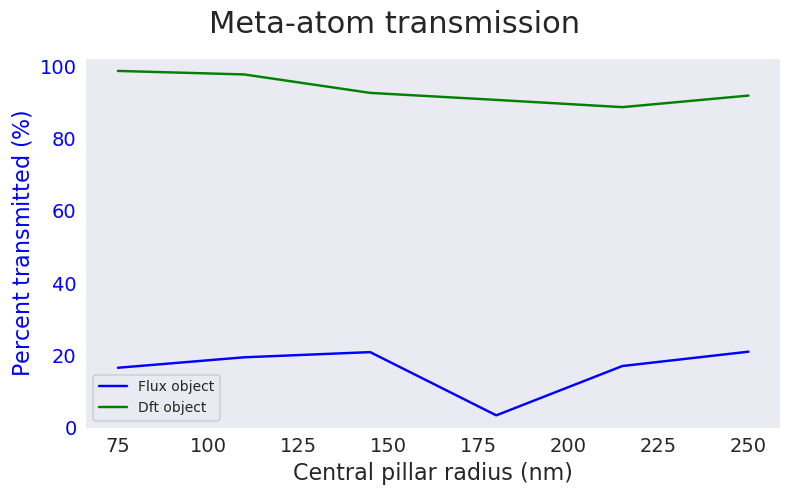

In [19]:
radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

#plt.style.use('seaborn')

results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phase and transmission
plt.style.use('seaborn-v0_8')

tickfontsize=14
labelfontsize=16
titlefontsize=22
padding = 0.02
plt.close("all")
fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom transmission",fontsize=titlefontsize)

ax.set_xlabel("Central pillar radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1+padding])
ax.set_ylabel(r'Percent transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Flux object')
ax.plot(radii,I_list,'green',label='Dft object')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

ax.legend(frameon=True, edgecolor='dimgrey')
# twin1 = ax.twinx()

# twin1.set_ylim([-np.pi,np.pi])
# twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
# twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
# twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
# twin1.plot(radii,phase_list,'r',label='Phase')
# twin1.tick_params(axis='y', labelcolor = 'red')

plt.grid(False)
plt.tight_layout()

In [ ]:
plt.close("all")
plt.figure(figsize=(8,8))
plot_plane = mp.Volume(center=mp.Vector3(0,0,fr_center),
                            size=mp.Vector3(cell_x,cell_y,0))
sim.plot2D(output_plane=plot_plane,
           #fields=mp.Ey
           )
plt.grid(False)

In [ ]:
sim.reset_meep()

## it would be interesting to see these characteristics for different random neighbors, as well as uniform neighbors

In [20]:
print(I_list)

[0.9870149083724464, 0.9773055062295207, 0.9262736908693775, 0.9068684624858437, 0.8868362231726779, 0.9188190344826134]


In [14]:
# I repeated this with high resolution using confirm_transmission.py. we see much more reasonable results with the high 
# resolution. also, using same resolution as our dataset.
import pickle
results = pickle.load(open("more_results.pkl","rb"))
results.keys()

dict_keys(['radii', 'trans', 'initial_I', 'eps_data', 'dft_slices'])

In [15]:
radii = results['radii']
I_list = results['trans']

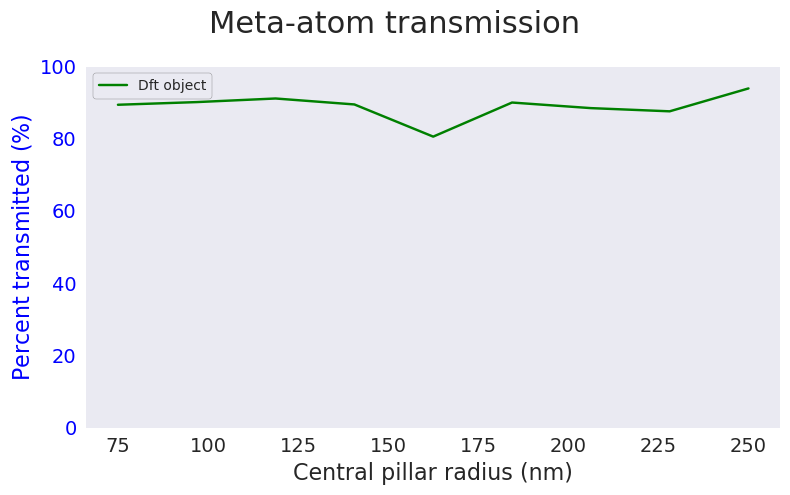

In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

tickfontsize=14
labelfontsize=16
titlefontsize=22
padding = 0.0
plt.close("all")
fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom transmission",fontsize=titlefontsize)

ax.set_xlabel("Central pillar radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1+padding])
ax.set_ylabel(r'Percent transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
#ax.plot(radii,flux_list,'b',label='Flux object')
ax.plot(radii,I_list,'green',label='Dft object')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

ax.legend(frameon=True, edgecolor='dimgrey')
# twin1 = ax.twinx()

# twin1.set_ylim([-np.pi,np.pi])
# twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
# twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
# twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
# twin1.plot(radii,phase_list,'r',label='Phase')
# twin1.tick_params(axis='y', labelcolor = 'red')

plt.grid(False)
plt.tight_layout()

In [17]:
max(I_list)

0.9392883712152892

In [19]:
min(I_list)

0.8058692654084691

In [20]:
results['initial_I']

0.02584613893357307